## Generación de Textos

En este ejercicio vamos a generar secuencias de texto de nobelas. La idea es utilizar una red LTSM  (“Long Short-Term Memory”)  implementeda en Keras. Si quieres profundizar el endentimiento de las redes LTSM se recomienda -> http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Los datos se pueden descaragar aquí https://www.kaggle.com/freecodecamp/all-posts-public-main-chatroom

Para este ejercicio se recomienda tener tensorflow con GPU instalada ya que es pesado de procesar

#### El Dataset

Posts extracted from a Gitter's public chatroom used for an online course to learn to program.

The files contains the posts from students, bots, moderators and contributors in the main ("/freeCodeCamp") Gitter chatroom between 31-Dec-2014 until the first days of Dec-2017. There are around 5 million posts from near 400,000 users (all estimates). Data was extracted using Python code over the Gitter API. Records are not anonymised or modified and are presented "as they are".

The datasets are a contribution from freeCodeCamp as part of the freeCodeCamp's Open Data Initiative. More information about the rationale of this initiative can be found in this announcement of us releasing the chat history dataset.

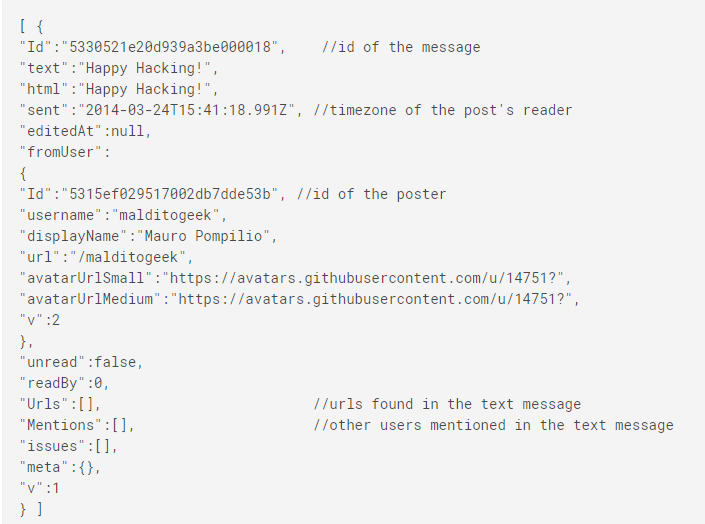

In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


Leemos los datos a procesar. Solo utilizamos 2 de las columnas

In [2]:
import pandas as pd
import numpy as np

# Unicamente dos de las columnas
chat = pd.read_csv('freecodecamp_casual_chatroom.csv', usecols = ['fromUser.id', 'text'])
# Removing user id for CamperBot
chat = chat[chat['fromUser.id'] != '55b977f00fc9f982beab7883'] 

chat.head()

,fromUser.id,text
0,546fd99cdb8155e6700d6ec8,no legumes either
1,54a47e0cdb8155e6700e486e,That bullet proof coffee sounds insane.
2,54a47e0cdb8155e6700e486e,That guy has huge eyes.
3,546fd99cdb8155e6700d6ec8,@janetwalters008 It is. but it works. some peo...
4,54a44bbbdb8155e6700e47de,They guy that came up with the idea is kind of...


In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

f, g = plt.subplots(figsize=(12, 9))
chat['fromUser.id'].value_counts().head(10).plot.bar(color="green")
g.set_xticklabels(g.get_xticklabels(), rotation=25)
plt.title("Most active users in freeCodeCamp's Gitter channel")
plt.show(g)

<Figure size 1200x900 with 1 Axes>

El usuario 55a7c9e08a7b72f55c3f991e, es el más activo con más de 140k mensajes. Vamos a utilizar sus mensajes para entrenar la red LTSM, por sentencias. No obstante, veamos primeros alguno de sus mensajes.

In [4]:
chat[chat['fromUser.id'] == "55a7c9e08a7b72f55c3f991e"].text.head(20)

224937    Hello... I heard about Free Code Camp via Life...
224977    So, just going through the prescribed steps (h...
225004    Looking for some idea on the average amount of...
225053    ok, I found the documentation (I'm new) on the...
225099    at what point does pair coding come into the p...
247053    do some amount of BASH here as well. Have to s...
247090    With all of the various frameworks (even some ...
247105    I'd like to see more variety in design as well...
247114    does the sameness (not specifically Bootstrap,...
247126    I've found that compiling a list (your own + l...
247127                                       syntax that is
253298    I find geany to be pretty solid (as far as edi...
253324    I'd imagine if you had experience programming ...
253325                                            edit: too
253912    I think (in addition to Monospace vs. Monotype...
253918          good to hear. CSS is more forgiving than js
253924    Very true. Sloppy code not onl

Preparamos el texto ahora para la entrada en la red LTSM. model.add(LSTM(batch_size, input_shape=(time_steps, features)))
- batch_size is the number of sequences in each sample (can be one or more), 
- time_steps is the size of observations in each sample, 
- features is the number of possible observable features (i.e., characters in our case)

Para hacer eso vamos a
- Hacer un subset de los datos de este usuario
- Formatear esos mensajes de manera que sean arrays semi-sobrepuestos de longitud uniforme y los siguientes caracteres
- Representar estos datos en tensores

In [5]:
user = chat[chat['fromUser.id'] == '55a7c9e08a7b72f55c3f991e'].text

n_messages = len(user)
n_chars = len(' '.join(map(str, user)))

print("55a7c9e08a7b72f55c3f991e contiene %d mensajes" % n_messages)
print("Todos estos mensajes son %d caracteres" % n_chars)

55a7c9e08a7b72f55c3f991e contiene 141362 mensajes
Todos estos mensajes son 7407104 caracteres


In [6]:
sample_size = int(len(user) * 0.2)

user = user[:sample_size]
user = ' '.join(map(str, user)).lower()

user[:100] # Veamos los primeros 100 caracteres

'hello... i heard about free code camp via lifehacker (i think: it was a feedly- feed) so, just going'

A continuación lo que hacemos es trasladar los caracteres a índices numéricos (las redes neuronales no entienden de letras).

In [7]:
chars = sorted(list(set(user)))
print('Número de caracteres distintos (i.e., features):', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Número de caracteres distintos (i.e., features): 149


Ahora fijamos las frases a una longitud máxima de 40 con los caracteres sobrepuestos = 3

In [8]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(user) - maxlen, step):
    sentences.append(user[i: i + maxlen])
    next_chars.append(user[i + maxlen])
print('Número de frases:', len(sentences), "\n")

print(sentences[:10], "\n")
print(next_chars[:10])

Número de frases: 490695 

['hello... i heard about free code camp vi', 'lo... i heard about free code camp via l', '.. i heard about free code camp via life', 'i heard about free code camp via lifehac', 'eard about free code camp via lifehacker', 'd about free code camp via lifehacker (i', 'bout free code camp via lifehacker (i th', 't free code camp via lifehacker (i think', 'ree code camp via lifehacker (i think: i', ' code camp via lifehacker (i think: it w'] 

['a', 'i', 'h', 'k', ' ', ' ', 'i', ':', 't', 'a']


Conversión a Tensores

In [9]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Generamos el modelo

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback, ModelCheckpoint
import random
import sys
import io

Using TensorFlow backend.


In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [12]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [13]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    # Function invoked for specified epochs. Prints generated text.
    # Using epoch+1 to be consistent with the training epochs printed by Keras
    if epoch+1 == 1 or epoch+1 == 15:
        print()
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = random.randint(0, len(user) - maxlen - 1)
        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print('----- diversity:', diversity)

            generated = ''
            sentence = user[start_index: start_index + maxlen]
            generated += sentence
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()
    else:
        print()
        print('----- Not generating text after Epoch: %d' % epoch)

generate_text = LambdaCallback(on_epoch_end=on_epoch_end)

In [14]:
# define the checkpoint
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# fit model using our gpu
with tf.device('/gpu:0'):
    model.fit(x, y,
              batch_size=128,
              epochs=15,
              verbose=2,
              callbacks=[generate_text, checkpoint])

Epoch 1/15
 - 206s - loss: 1.9561

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " course was lacking in clear direction ("
 course was lacking in clear direction (or the stack the back it was a lot of the some linux it was a content the back it was a basic i was the langures is the start (and it the seen the start it work and something is the start is the linux what i think it was a lot of the stand it was a blot of the stack is the back it was a back it have a bad the stall (and the stack the code (it would be a lot of the first it has a blan are the compl
----- diversity: 0.5
----- Generating with seed: " course was lacking in clear direction ("
 course was lacking in clear direction (while is my the from a first it part the with @eraninrmall are you that is the ble the redickor) and a plane desorry the compette it would be hor the state although and a look good complies differs it an i think background read the still are the link it is the lo

c:\anaconda3\envs\flappybird\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


the code and there's a work in the code and there's a lot of the string (i don't have to see the code there are the really someth
----- diversity: 0.5
----- Generating with seed: "for those that do) with gas station coff"
for those that do) with gas station coffee so i get people later the exercise is and read second done the good the first can't have an i don't it does the paramigries list with it with the staten of there are a best for code in problem i think there's a bottom over that was not a code or angular with the show up all the angular files are me will one compliped it wise in the cases and will see a good the close many way but it was so the 
----- diversity: 1.0
----- Generating with seed: "for those that do) with gas station coff"
for those that do) with gas station coffees weather.sfg  @sttflotoyse return @storbeck @c fant you have better on the kind on')  i've fow (versed) ughtbuty almost jdage id @holergha you're hi @stonfiromkstolled i haven't look for 'schin,... it w